In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [11]:
# Training data is 100 points in [0,1] inclusive regularly spaced
train_x = torch.linspace(0, 1, 100)
# True function is sin(2*pi*x) with Gaussian noise
train_y = torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * math.sqrt(0.04)

In [3]:
# most critical feature of user-defined Gaussian process
# gpytorch do NOT provided full GP model for the user.
# instead provide tools necessary to quickly construct one (GP)


following GPytorch objects:
1. A GP Model `(gpytorch.models.ExactGP)` - This handles most of the inference.

2. A Likelihood `(gpytorch.likelihoods.GaussianLikelihood)` - This is the most common likelihood used for GP regression.

3. A Mean - This defines the prior mean of the GP.(If you don’t know which mean to use, a `gpytorch.means.ConstantMean()` is a good place to start.)

4. A Kernel - This defines the prior covariance of the GP.(If you don’t know which kernel to use, a `gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())` is a good place to start).

5. A MultivariateNormal Distribution `(gpytorch.distributions.MultivariateNormal)` - This is the object used to represent multivariate normal distributions.

In [ ]:
# two kernels via addition
# add the kernel modules directly:
## self.covar_module = ScaleKernel(RBFKernel() + LinearKernel())

# add the outputs of the kernel in the forward method:
# covar#_x = self.rbf_kernel_module(x) + self.white_noise_module(x)

The simplest likelihood for regression is the gpytorch.likelihoods.GaussianLikelihood. This assumes a homoskedastic noise model (i.e. all inputs have the same observational noise).

Recall: \
`train_x = torch.linspace(0, 1, 100)` \
`train_y = torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * math.sqrt(0.04)`

In [9]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

##### Traning

In GPyTorch, we make use of the standard PyTorch optimizers as from `torch.optim`, and all trainable parameters of the model should be of type `torch.nn.Parameter`. \
Because GP models directly extend `torch.nn.Module`, calls to methods like `model.parameters()` or `model.named_parameters()` function as you might expect coming from PyTorch.

In most cases, the boilerplate code below will work well. It has the same basic components as the standard PyTorch training loop:

1. Zero all parameter gradients

2. Call the model and compute the loss

3. Call backward on the loss to fill in gradients

4. Take a step on the optimizer

In [12]:
# # this is for running the notebook in our testing framework
# import os
# smoke_test = ('CI' in os.environ)
# training_iter = 2 if smoke_test else 50
training_iter = 50

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.09)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item()
    ))
    optimizer.step()

Iter 1/50 - Loss: 0.729   lengthscale: 0.447   noise: 0.469
Iter 2/50 - Loss: 0.680   lengthscale: 0.415   noise: 0.436
Iter 3/50 - Loss: 0.633   lengthscale: 0.386   noise: 0.405
Iter 4/50 - Loss: 0.588   lengthscale: 0.358   noise: 0.376
Iter 5/50 - Loss: 0.547   lengthscale: 0.333   noise: 0.349
Iter 6/50 - Loss: 0.510   lengthscale: 0.311   noise: 0.323
Iter 7/50 - Loss: 0.475   lengthscale: 0.292   noise: 0.299
Iter 8/50 - Loss: 0.442   lengthscale: 0.276   noise: 0.276
Iter 9/50 - Loss: 0.409   lengthscale: 0.262   noise: 0.255
Iter 10/50 - Loss: 0.377   lengthscale: 0.252   noise: 0.235
Iter 11/50 - Loss: 0.345   lengthscale: 0.243   noise: 0.217
Iter 12/50 - Loss: 0.313   lengthscale: 0.236   noise: 0.200
Iter 13/50 - Loss: 0.280   lengthscale: 0.231   noise: 0.184
Iter 14/50 - Loss: 0.248   lengthscale: 0.227   noise: 0.169
Iter 15/50 - Loss: 0.216   lengthscale: 0.224   noise: 0.156
Iter 16/50 - Loss: 0.183   lengthscale: 0.223   noise: 0.143
Iter 17/50 - Loss: 0.152   length

#### Make predictions with the model

To do this, we simply put the model and likelihood in eval mode, and call both modules on the test data. \
Just as a user defined GP model returns a MultivariateNormal containing the prior mean and covariance from forward, \
a trained GP model in eval mode returns a MultivariateNormal containing the `posterior` mean and covariance.

If we denote a test point (test_x) as x* with the true output being y*, then model(test_x) returns the model posterior distribution `p(f* | x*, X, y)`, \
for training data X, y. This posterior is the distribution over the function we are trying to model, and thus quantifies our model uncertainty.

In contrast, likelihood(model(test_x)) gives us the posterior predictive distribution `p(y* | x*, X, y)` \
which is the probability distribution over the predicted output value. Recall in our problem setup

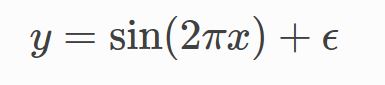

In [16]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, 1, 51)
    observed_pred = likelihood(model(test_x))

In [17]:
f_preds = model(test_x)
y_preds = likelihood(model(test_x))

f_mean = f_preds.mean
f_var = f_preds.variance
f_covar = f_preds.covariance_matrix
f_samples = f_preds.sample(sample_shape=torch.Size(1000,))

TypeError: 'int' object is not iterable

#### Plot the model fit
We plot the mean and confidence region of the Gaussian process model. \
The confidence_region method is a helper method that returns 2 standard deviations above and below the mean.

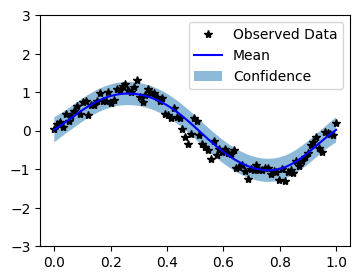

In [18]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(4, 3))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])